# Biodiversity in National Parks

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import csv
import statsmodels.api as sm
import math
import statsmodels

## Introduction

The goal of the current project is to analyse the biodiversity of the United States of America National Parks, using data from the National Parks Service.

The project will scope, clean, prepare, analyse and visualise data, in an attempt to explain the findings made by the analysis.

### Project Goals

The main goal of this project is to analyse the biodiversity of the National Parks. Because the main concern of the National Parks is to understand which species are at-risk, so that they can take action to protect these species, the goals of the project will be related to this. These will be:

- What is the distribution of conservation status for species?
- Are certain types of species more likely to be endangered?
- Are there differences between species and their conservation status significant?

These three questions need to be answered in order for the National Parks Service to be able to identify the more at-risk species and take action in order to protect them. 

### Data

The data for this project was provided by Codecademy.com and is a fictional dataset, based on real data. The data is divided into two dataset - 'species.csv' and 'parks.csv'. These have information on the species and information on observations of species in the parks, respectively.

In [7]:
df_observations = pd.read_csv('observations.csv')
df_species = pd.read_csv('species_info.csv')

In [ ]:
# observing the data in each dataset
print(df_observations.head())
print(df_species.head())

# observing the columns each dataset has
print(df_observations.columns)
print(df_species.columns)

# observing the shape of the data
print(df_observations.shape)
print(df_species.shape)

The two dataframes are composed of:

- Species - **category** (The category of taxonomy for each species), **scientific_name** (The species scientific name), **common_names** (The names commonly used for this species), **conservation_status** (The species conservation status)
- Observations = **scientific_name** (Same as above), **park_name** (Name of the park the observation occured), **observations** (Number of observations made in the last 7 days)

#### Data Exploration

Species.csv Dataset exploration

In [8]:
# let's start with finding out many unique species are in the dataset
print(f"Number of unique species: {df_species.scientific_name.nunique()}")

# next, let's see how many different categories there are, and what their names are
print(f"There are {df_species.category.nunique()} different categories of beings in the forests.")
print(f"Their names are:{df_species.category.unique()}")

# let's dig deeper and see how many species of each category there are
print(df_species.groupby("category").size())


# now let's explore the conservation_status variable, in the same way we did the category one
print(f"There are 4 different possible status a species is in, these are: {df_species.conservation_status.unique()}")

# let's see how many species correspond to each status
print(df_species.groupby("conservation_status").size())

# it seems like a lot of species are missing in this count. Let's see how many values are missing
print(f"There are {df_species.conservation_status.isna().sum()} missing values in the conservation status columns.")

Number of unique species: 5541
There are 7 different categories of beings in the forests.
Their names are:['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']
category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64
There are 4 different possible status a species is in, these are: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']
conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64
There are 5633 missing values in the conservation status columns.


In [9]:
# checking number of parks in the dataset
print(f"There are {df_observations.park_name.nunique()} different parks in this dataset.")
print(f"These are: {df_observations.park_name.unique()}")

# number of observations
print(f"There were a total of {df_observations.observations.sum()} observations recorded in the last 7 days.")

# lets see number of observations accross each park
print(df_observations.groupby("park_name").sum())

There are 4 different parks in this dataset.
These are: ['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']
There were a total of 3314739 observations recorded in the last 7 days.
                                     observations
park_name                                        
Bryce National Park                        576025
Great Smoky Mountains National Park        431820
Yellowstone National Park                 1443562
Yosemite National Park                     863332


### Analysis

- What is the distribution of conservation status for species?


Initially, we need to clean the conservation_status column. Luckily, since its NaN values aren't actually NaN, all we have to do is give them a name.

In [10]:
df_species.conservation_status.fillna("No Concern", inplace=True)
print(df_species.groupby("conservation_status").size())

conservation_status
Endangered              16
In Recovery              4
No Concern            5633
Species of Concern     161
Threatened              10
dtype: int64


Now let's see how each category is doing in terms of its conservation status. Are there specific categories significantly more at risk than other?

In [11]:
categories_conservation_values = df_species[df_species.conservation_status != "No Concern"]\
                                    .groupby(["conservation_status", "category"])["scientific_name"]\
                                    .count().unstack()

print(categories_conservation_values)

category             Amphibian  Bird  Fish  Mammal  Nonvascular Plant  \
conservation_status                                                     
Endangered                 1.0   4.0   3.0     7.0                NaN   
In Recovery                NaN   3.0   NaN     1.0                NaN   
Species of Concern         4.0  72.0   4.0    28.0                5.0   
Threatened                 2.0   NaN   4.0     2.0                NaN   

category             Reptile  Vascular Plant  
conservation_status                           
Endangered               NaN             1.0  
In Recovery              NaN             NaN  
Species of Concern       5.0            43.0  
Threatened               NaN             2.0  


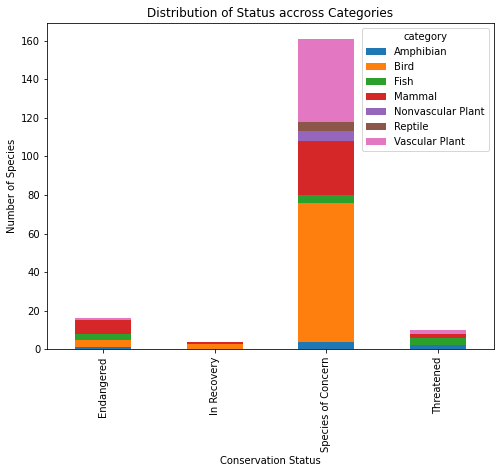

In [12]:
# Visualising this distribution
ax = categories_conservation_values.plot(kind = 'bar', figsize=(8, 6), 
                                         stacked = True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species")
ax.set_title("Distribution of Status accross Categories");

- Are certain types of species more likely to be endangered?

In order to see if different categories are indeed more likely to be endagered, we will need a new collumn called "Concern" which will aggregate all the different status that are not "No Concern". Then, we will see the percentage of total animals within each category, to see which one has the biggest percentage of animals as being of concern.

In [13]:
df_species["concern"] = df_species.conservation_status != "No Concern"
category_counts = df_species.groupby(["category", "concern"])\
                    .scientific_name.nunique().reset_index()\
                    .pivot(columns='concern', index='category', 
                          values = 'scientific_name').reset_index()

category_counts.columns = ['category', 'not_protected', 'protected']
category_counts['percentage'] = category_counts.protected/ \
                                (category_counts.protected + category_counts.not_protected) \
                                * 100
print(category_counts)

            category  not_protected  protected  percentage
0          Amphibian             72          7    8.860759
1               Bird            413         75   15.368852
2               Fish            115         11    8.730159
3             Mammal            146         30   17.045455
4  Nonvascular Plant            328          5    1.501502
5            Reptile             73          5    6.410256
6     Vascular Plant           4216         46    1.079305


- Are the differences between species and their conservation status significant?

In order to analyse the difference between different species we will be using Chi-Squared tests.

In [14]:
from scipy.stats import chi2_contingency

# is there a difference between mammals and birds?
contengincy1 = [[30, 146],
               [75, 413]]
print(f"Chi-Squared for mammals and birds: {chi2_contingency(contengincy1)}") # p-value = 0.69 not significant

# mammals and reptiles
contengincy2 = [[30, 146],
               [5, 73]]
print(f"Chi-Squared for mammals and reptiles: {chi2_contingency(contengincy2)}") # p-value = 0.04 significant

# mammals and fish
contengincy3 = [[30, 146],
               [11, 115]]
print(f"Chi-Squared for mammals and fish: {chi2_contingency(contengincy3)}") # p-value = 0.06 non-signficant

# mammals and amphibians
contengincy4 = [[30, 146],
               [7, 72]]
print(f"Chi-Squared for mammals and amphibians: {chi2_contingency(contengincy4)}") # p-value = 0.13 non-significant

# mammals and Nonvascular Plants
contengincy8 = [[30, 146],
               [5, 328]]
print(f"Chi-Squared for mammals and Nonvascular Plants: {chi2_contingency(contengincy8)}") # p-value < 0.01 significant

# mammals and Vascular Plants
contengincy9 = [[30, 146],
               [46, 4216]]
print(f"Chi-Squared for mammals and Vascular Plants: {chi2_contingency(contengincy9)}") # p-value < 0.001 significant


# birds and reptiles
contengincy5 = [[75, 413],
               [5, 73]]
print(f"Chi-Squared for birds and reptiles: {chi2_contingency(contengincy5)}") # p-value = 0.05 significant

# birds and fish
contengincy6 = [[75, 413],
               [11, 115]]
print(f"Chi-Squared for birds and fish: {chi2_contingency(contengincy6)}") # p-value = 0.08 non-significant

# birds and amphibians
contengincy7 = [[75, 413],
               [7, 72]]
print(f"Chi-Squared for birds and amphibians: {chi2_contingency(contengincy7)}") # p-value = 0.17 non-significant

# birds and Nonvascular Plants
contengincy10 = [[75, 413],
               [5, 328]]
print(f"Chi-Squared for birds and Nonvascular Plants: {chi2_contingency(contengincy10)}") # p-value < 0.001 significant

# birds and Vascular Plants
contengincy11 = [[75, 413],
               [46, 4216]]
print(f"Chi-Squared for birds and Vascular Plants: {chi2_contingency(contengincy11)}") # p-value < 0.001 significant

Chi-Squared for mammals and birds: (0.1617014831654557, 0.6875948096661336, 1, array([[ 27.8313253, 148.1686747],
       [ 77.1686747, 410.8313253]]))
Chi-Squared for mammals and reptiles: (4.289183096203645, 0.03835559022969898, 1, array([[ 24.2519685, 151.7480315],
       [ 10.7480315,  67.2519685]]))
Chi-Squared for mammals and fish: (3.647651024981415, 0.0561483484489001, 1, array([[ 23.89403974, 152.10596026],
       [ 17.10596026, 108.89403974]]))
Chi-Squared for mammals and amphibians: (2.321746712946015, 0.12757669693198975, 1, array([[ 25.5372549, 150.4627451],
       [ 11.4627451,  67.5372549]]))
Chi-Squared for mammals and Nonvascular Plants: (41.0526001992972, 1.481868915759314e-10, 1, array([[ 12.1021611, 163.8978389],
       [ 22.8978389, 310.1021611]]))
Chi-Squared for mammals and Vascular Plants: (246.5870424874456, 1.4405067309854046e-55, 1, array([[3.01397026e+00, 1.72986030e+02],
       [7.29860297e+01, 4.18901397e+03]]))
Chi-Squared for birds and reptiles: (3.739654

## Discussion


The current project was done with the ultimate goal of informing decision-making in the National Parks Service with regard to what species need more protection from environmental pressures, so as to avoid extinction.

With this in mind, the first question that was answered was "What is the distribution of conservation status for species". In answering this question, we were able to see that the most common conservation status among species was "Species of Concern", which had 161 species total. Overall, there were 5633 species that had no Conservation Status, deemed "No Concern" in this project, and 191 species that were highlighted with some form of Conservation Status. 

The next question addressed by this report was if there are certain types of species that are more likely to be endangered. We demonstrated how Birds and Mammals have a bigger percentage of their population than any other category. This was in contrast with the absolute numbers which had shown that Vascular Plants had the biggest number of species marked with some form of conservation status. 

In order to fully comprehend if there is a difference between Birds and Mammals and the rest of the species in the dataset, we ran a Chi-Squared statistical significant test between these two categories and the others. These tests demonstrated that there is no difference between Mammals and Birds as well as between these two and Fish and Amphibians. It did, however, demonstrate a significant difference between these two categories and Nonvascular Plants, Vascular Plants as well as Reptiles. 

## Future Research

Future research could expand on the current report by including more data. Because the "observations" column only has data relevant to the last 7 days, some bias in the data is to be expected. As such, future research could use more expansive data, and perform analysis over the course of much longer periods of time, which would invariably give much more precise results. 

Further, the current observations dataset only had general information for each park, however, it is to be expected that different species perform better in different areas, something that the current report did not have access to. 

Finally, future research could attempt to explore how specific species of Mammals, Birds, Fish, and Amphibians are doing. This could only be done with a lot of upfront subject knowledge, that would inform which species to analyse first, so future research that attempts to do so would need collaboration with subject experts. 